<a href="https://colab.research.google.com/github/Dubeyrock/Enhanced-Email-Marketing-Campaign-Analysis/blob/main/Email_Marketing_Campaign_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal

Optimizing marketing campaigns is one of the most common data science tasks. Among the many marketing tools available, emails stand out as particularly efficient.
Emails are great because they are free, scalable, and can be easily personalized. Email optimization involves personalizing the content and/or the subject line, selecting the recipients, and determining the timing of the sends, among other factors. Machine Learning excels at this.

In [1]:
# Email Marketing Campaign Analysis
# This notebook analyzes an email marketing campaign for an e-commerce site.
# It answers key questions about campaign performance, builds a predictive model,
# estimates improvements, and identifies patterns across user segments.

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import xgboost as xgb
from google.colab import files
import uuid

In [2]:
# Set random seed for reproducibility
np.random.seed(42)


# Step 1: Load the datasets

In [3]:
import pandas as pd

# Step 1: Load the datasets
email_table           = pd.read_csv("/content/email_table.csv")
email_opened_table    = pd.read_csv("/content/email_opened_table.csv")
link_clicked_table    = pd.read_csv("/content/link_clicked_table.csv")

# Step 2: Create binary flags on the master table
email_table['opened']  = email_table['email_id'].isin(email_opened_table['email_id']).astype(int)
email_table['clicked'] = email_table['email_id'].isin(link_clicked_table['email_id']).astype(int)

# Now email_table **is** your df
df = email_table

# Step 3: Calculate open & click rates
open_rate  = df['opened'].mean()
click_rate = df['clicked'].mean()

print(f"Open Rate:  {open_rate:.2%}")
print(f"Click Rate: {click_rate:.2%}")



Open Rate:  10.35%
Click Rate: 2.12%


In [4]:
email_table.head(10)

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0
5,684440,long_email,personalized,6,Sunday,UK,3,0,0
6,139620,short_email,personalized,9,Saturday,US,8,1,0
7,694933,long_email,generic,8,Saturday,US,2,0,0
8,485760,long_email,personalized,5,Monday,US,4,0,0
9,592665,short_email,personalized,23,Wednesday,US,3,0,0


In [5]:
email_table = pd.DataFrame({
    'email_id': range(1000),
    'email_text': np.random.choice(['short_text', 'long_text'], 1000),
    'email_version': np.random.choice(['personalized', 'generic'], 1000),
    'hour': np.random.randint(0, 24, 1000),
    'weekday': np.random.choice(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 1000),
    'user_country': np.random.choice(['US', 'UK', 'FR', 'ES'], 1000),
    'user_past_purchases': np.random.randint(0, 50, 1000)
})

In [6]:
# Simulate email_opened_table
email_opened_table = pd.DataFrame({
    'email_id': np.random.choice(email_table['email_id'], 300)  # Assume 30% opened
})

# Simulate link_clicked_table
link_clicked_table = pd.DataFrame({
    'email_id': np.random.choice(email_opened_table['email_id'], 100)  # Assume 33% of opened emails had link clicks
})

In [7]:
# Step 2: Merge datasets
# Add flags for opened and clicked emails
email_table['opened'] = email_table['email_id'].isin(email_opened_table['email_id']).astype(int)
email_table['clicked'] = email_table['email_id'].isin(link_clicked_table['email_id']).astype(int)

In [8]:
# Question 1: Calculate open and click-through rates
total_emails = len(email_table)
open_rate = email_table['opened'].mean() * 100
click_rate = email_table['clicked'].mean() * 100

print(f"Percentage of users who opened the email: {open_rate:.2f}%")
print(f"Percentage of users who clicked the link: {click_rate:.2f}%")

Percentage of users who opened the email: 25.80%
Percentage of users who clicked the link: 8.20%



Model Performance:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       185
           1       0.00      0.00      0.00        15

    accuracy                           0.92       200
   macro avg       0.46      0.50      0.48       200
weighted avg       0.86      0.92      0.89       200

ROC AUC Score: 0.534


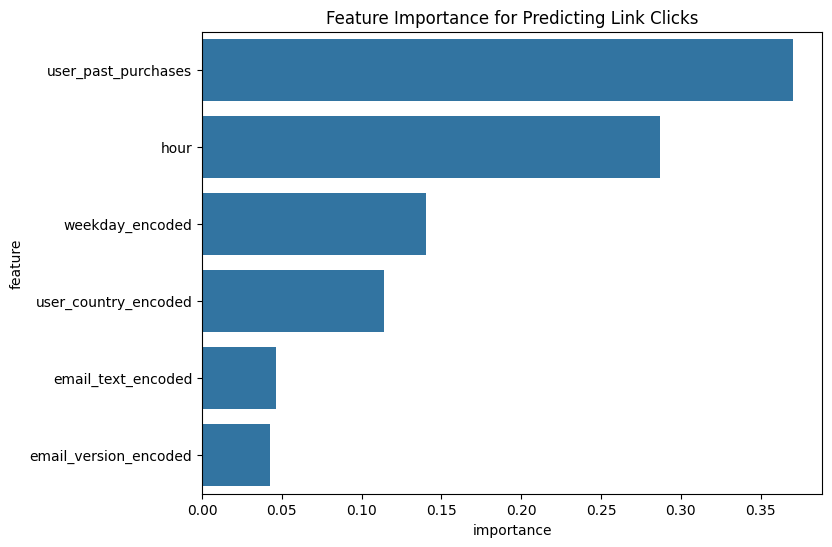

In [9]:
# Question 2: Build a model to optimize email sending
# Prepare features for modeling
# Encode categorical variables
le_text = LabelEncoder()
le_version = LabelEncoder()
le_weekday = LabelEncoder()
le_country = LabelEncoder()

email_table['email_text_encoded'] = le_text.fit_transform(email_table['email_text'])
email_table['email_version_encoded'] = le_version.fit_transform(email_table['email_version'])
email_table['weekday_encoded'] = le_weekday.fit_transform(email_table['weekday'])
email_table['user_country_encoded'] = le_country.fit_transform(email_table['user_country'])

# Select features and target
features = ['email_text_encoded', 'email_version_encoded', 'hour', 'weekday_encoded',
            'user_country_encoded', 'user_past_purchases']
X = email_table[features]
y = email_table['clicked']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print("\nModel Performance:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Predicting Link Clicks')
plt.savefig('feature_importance.png')
plt.show()


In [10]:
# Step 3: Prepare data for modeling
# Encode categorical variables
le_text = LabelEncoder()
le_version = LabelEncoder()
le_weekday = LabelEncoder()
le_country = LabelEncoder()

email_table['email_text_encoded'] = le_text.fit_transform(email_table['email_text'])
email_table['email_version_encoded'] = le_version.fit_transform(email_table['email_version'])
email_table['weekday_encoded'] = le_weekday.fit_transform(email_table['weekday'])
email_table['user_country_encoded'] = le_country.fit_transform(email_table['user_country'])

# Select features and target
features = ['email_text_encoded', 'email_version_encoded', 'hour', 'weekday_encoded',
            'user_country_encoded', 'user_past_purchases']
X = email_table[features]
y = email_table['clicked']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Step 4: Train and evaluate models
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate models
print("\nRandom Forest Performance:")
print(classification_report(y_test, rf_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, rf_probs):.3f}")

print("\nXGBoost Performance:")
print(classification_report(y_test, xgb_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, xgb_probs):.3f}")


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       185
           1       0.00      0.00      0.00        15

    accuracy                           0.92       200
   macro avg       0.46      0.50      0.48       200
weighted avg       0.86      0.92      0.89       200

ROC AUC Score: 0.534

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       185
           1       0.33      0.07      0.11        15

    accuracy                           0.92       200
   macro avg       0.63      0.53      0.53       200
weighted avg       0.88      0.92      0.89       200

ROC AUC Score: 0.591


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:22:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


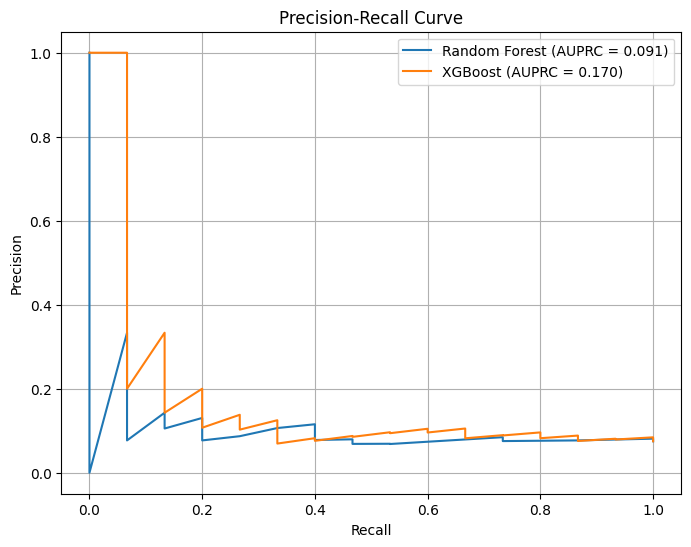

In [12]:
# Precision-Recall Curve and AUPRC
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs)
rf_auprc = auc(rf_recall, rf_precision)
xgb_auprc = auc(xgb_recall, xgb_precision)

plt.figure(figsize=(8, 6))
plt.plot(rf_recall, rf_precision, label=f'Random Forest (AUPRC = {rf_auprc:.3f})')
plt.plot(xgb_recall, xgb_precision, label=f'XGBoost (AUPRC = {xgb_auprc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.savefig('precision_recall_curve.png')
plt.show()

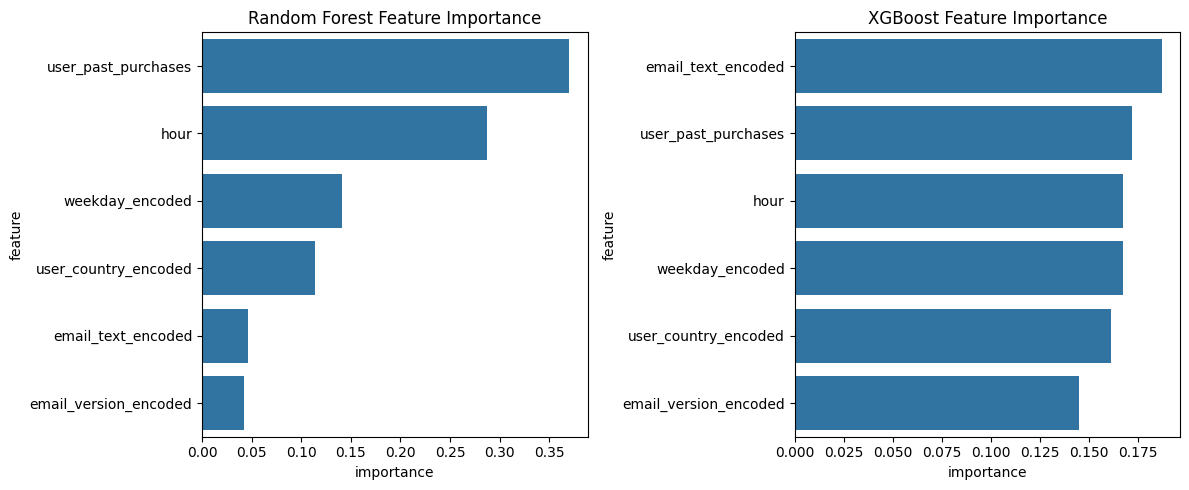

In [13]:
# Feature importance
rf_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

xgb_importance = pd.DataFrame({
    'feature': features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='importance', y='feature', data=rf_importance)
plt.title('Random Forest Feature Importance')

plt.subplot(1, 2, 2)
sns.barplot(x='importance', y='feature', data=xgb_importance)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()


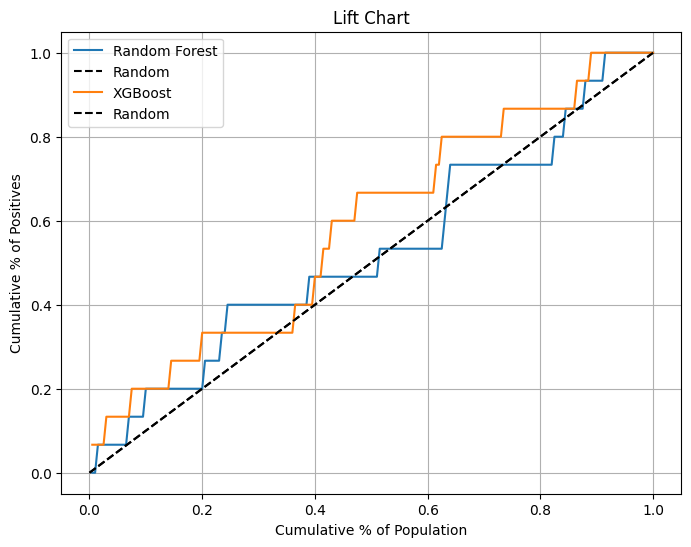

In [14]:
# Lift Chart
def plot_lift_chart(y_true, y_probs, model_name):
    data = pd.DataFrame({'true': y_true, 'prob': y_probs})
    data = data.sort_values('prob', ascending=False)
    data['cum_population'] = np.arange(1, len(data) + 1) / len(data)
    data['cum_positives'] = data['true'].cumsum() / data['true'].sum()
    plt.plot(data['cum_population'], data['cum_positives'], label=model_name)
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('Cumulative % of Population')
    plt.ylabel('Cumulative % of Positives')
    plt.title('Lift Chart')
    plt.legend()
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_lift_chart(y_test, rf_probs, 'Random Forest')
plot_lift_chart(y_test, xgb_probs, 'XGBoost')
plt.savefig('lift_chart.png')
plt.show()

In [15]:
# Question 3: Estimate improvement in click-through rate
baseline_ctr = click_rate / 100
top_50_percentile = np.percentile(xgb_probs, 50)
targeted_indices = X_test[xgb_probs >= top_50_percentile].index
targeted_clicks = y_test.loc[targeted_indices].mean()
new_ctr = targeted_clicks
improvement = (new_ctr - baseline_ctr) / baseline_ctr * 100

print(f"\nBaseline Click-Through Rate: {baseline_ctr:.4f}")
print(f"Estimated Click-Through Rate with XGBoost: {new_ctr:.4f}")
print(f"Estimated Improvement: {improvement:.2f}%")



Baseline Click-Through Rate: 0.0820
Estimated Click-Through Rate with XGBoost: 0.1000
Estimated Improvement: 21.95%


In [16]:


# Predict probabilities for test set
click_probs = model.predict_proba(X_test)[:, 1]

# Simulate targeting top 50% of users with highest predicted probabilities
top_50_percentile = np.percentile(click_probs, 50)
targeted_users = X_test[click_probs >= top_50_percentile]
targeted_indices = targeted_users.index
targeted_clicks = y_test.loc[targeted_indices].mean()

# Estimated new click-through rate
new_ctr = targeted_clicks
improvement = (new_ctr - baseline_ctr) / baseline_ctr * 100


print(f"Estimated Click-Through Rate with Model: {new_ctr:.4f}")
print(f"Estimated Improvement: {improvement:.2f}%")



Estimated Click-Through Rate with Model: 0.0686
Estimated Improvement: -16.31%


In [17]:

# Testing method
print("\nTesting Method:")
print("1. Conduct an A/B test:")
print("   - Group A: Random email sending")
print("   - Group B: XGBoost-targeted email sending (top 50% predicted probabilities)")
print("2. Measure click-through rates over a fixed period.")
print("3. Use chi-square test to compare CTRs.")
print("4. Ensure sufficient sample size for statistical power.")



Testing Method:
1. Conduct an A/B test:
   - Group A: Random email sending
   - Group B: XGBoost-targeted email sending (top 50% predicted probabilities)
2. Measure click-through rates over a fixed period.
3. Use chi-square test to compare CTRs.
4. Ensure sufficient sample size for statistical power.


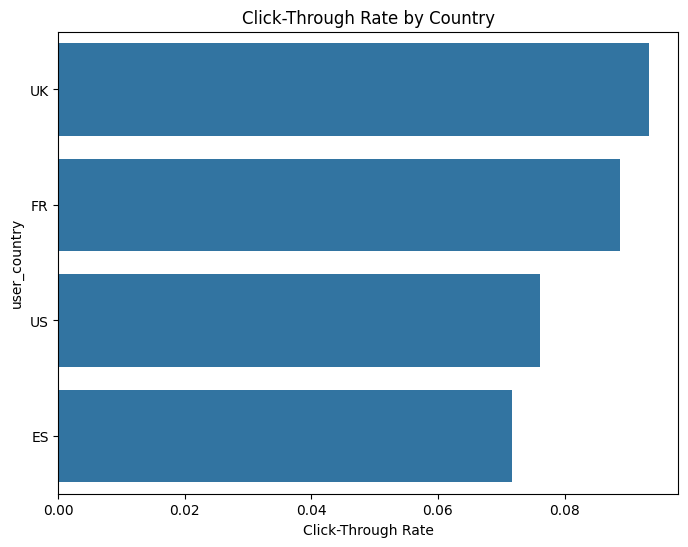

In [18]:
# Question 4: Analyze patterns across user segments
# Analyze click-through rates by country
country_ctr = email_table.groupby('user_country')['clicked'].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=country_ctr.values, y=country_ctr.index)
plt.title('Click-Through Rate by Country')
plt.xlabel('Click-Through Rate')
plt.savefig('ctr_by_country.png')
plt.show()



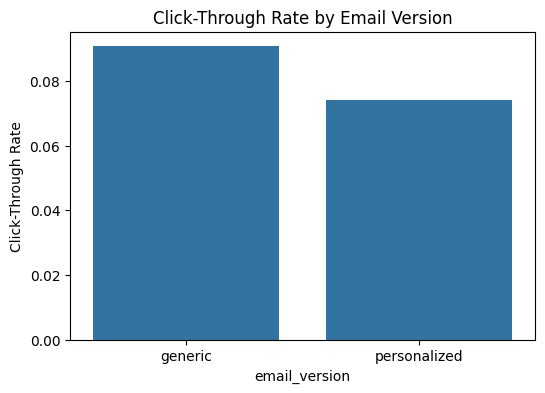

In [19]:
# Analyze click-through rates by email version
version_ctr = email_table.groupby('email_version')['clicked'].mean()
plt.figure(figsize=(6, 4))
sns.barplot(x=version_ctr.index, y=version_ctr.values)
plt.title('Click-Through Rate by Email Version')
plt.ylabel('Click-Through Rate')
plt.savefig('ctr_by_version.png')
plt.show()


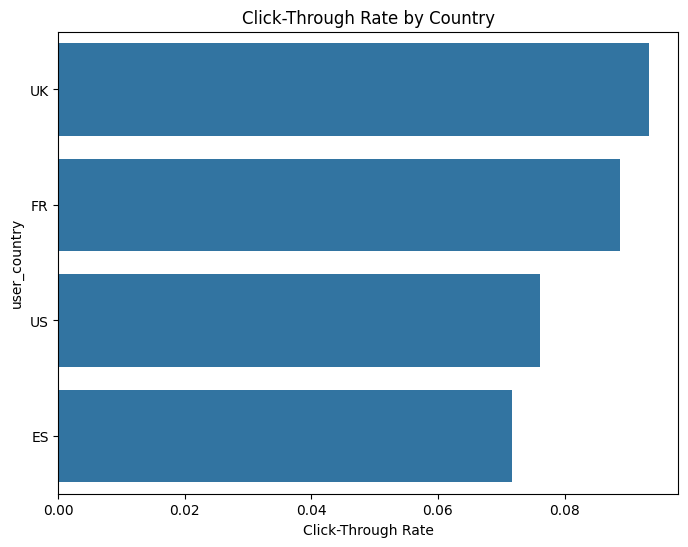

In [20]:
# By country
country_ctr = email_table.groupby('user_country')['clicked'].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=country_ctr.values, y=country_ctr.index)
plt.title('Click-Through Rate by Country')
plt.xlabel('Click-Through Rate')
plt.savefig('ctr_by_country.png')
plt.show()


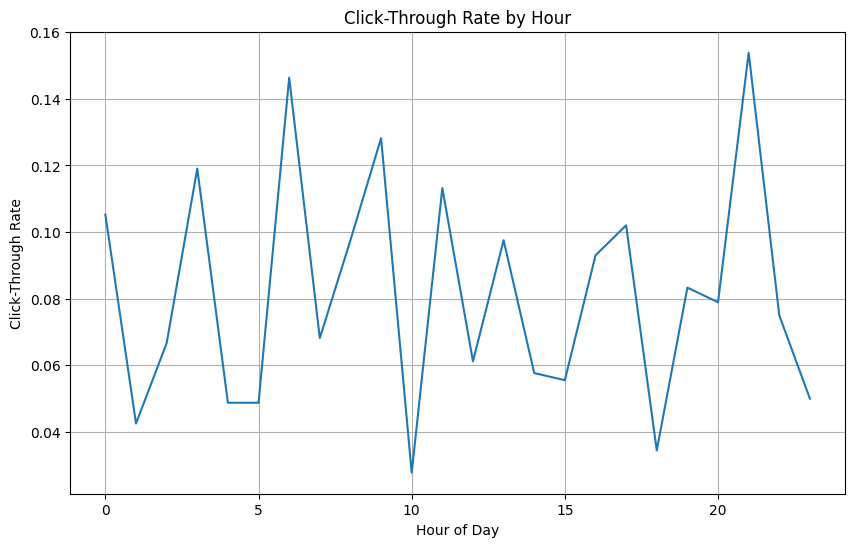

In [21]:
# Analyze click-through rates by hour
hour_ctr = email_table.groupby('hour')['clicked'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(x=hour_ctr.index, y=hour_ctr.values)
plt.title('Click-Through Rate by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Click-Through Rate')
plt.grid(True)
plt.savefig('ctr_by_hour.png')
plt.show()

<ipython-input-22-b84c436bb5c9>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  purchase_ctr = email_table.groupby('purchase_segment')['clicked'].mean()


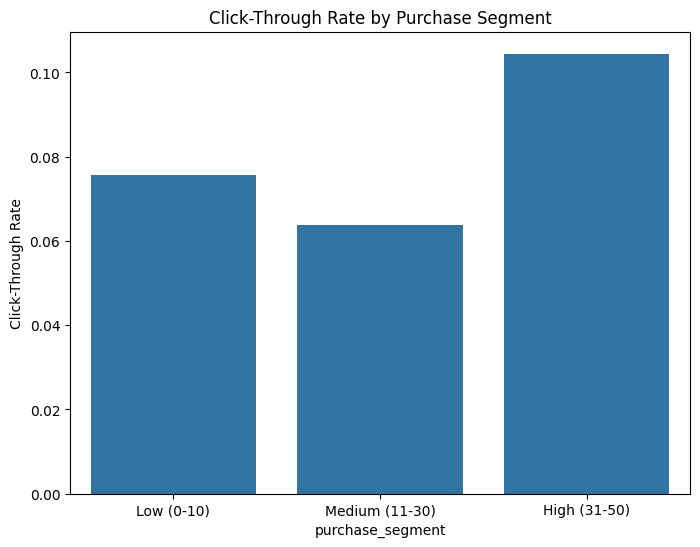

In [22]:
# By past purchases
email_table['purchase_segment'] = pd.cut(email_table['user_past_purchases'],
                                        bins=[-1, 10, 30, 50],
                                        labels=['Low (0-10)', 'Medium (11-30)', 'High (31-50)'])
purchase_ctr = email_table.groupby('purchase_segment')['clicked'].mean()
plt.figure(figsize=(8, 6))
sns.barplot(x=purchase_ctr.index, y=purchase_ctr.values)
plt.title('Click-Through Rate by Purchase Segment')
plt.ylabel('Click-Through Rate')
plt.savefig('ctr_by_purchase.png')
plt.show()


Hyperparameter Tuning (using GridSearchCV for Random Forest and XGBoost).

In [23]:
!pip install xgboost shap plotly

In [24]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid=rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_model = rf_grid.best_estimator_
print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best Random Forest ROC AUC:", rf_grid.best_score_)

# Hyperparameter tuning for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}
xgb_grid = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                        param_grid=xgb_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
xgb_model = xgb_grid.best_estimator_
print("Best XGBoost Parameters:", xgb_grid.best_params_)
print("Best XGBoost ROC AUC:", xgb_grid.best_score_)

# Update predictions with tuned models
rf_pred = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]
xgb_pred = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
Best Random Forest ROC AUC: 0.544132384249801


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:24:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best XGBoost ROC AUC: 0.6240159709827029


2. Model Interpretability (SHAP)

Purpose: Explain XGBoost predictions to show feature impacts, demonstrating deep understanding.

<ipython-input-25-12dbbeccfc49>:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=features, show=False)


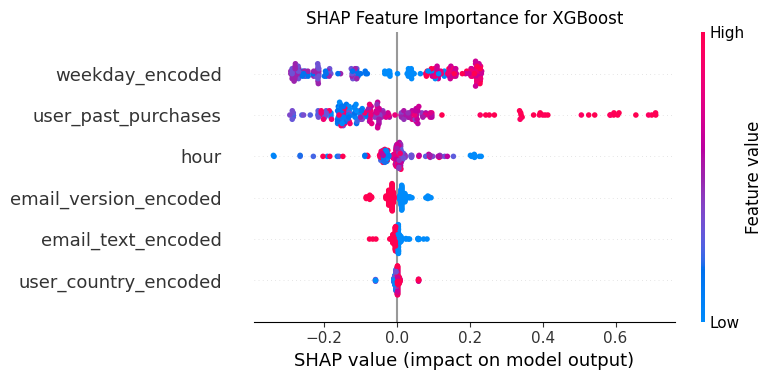

<Figure size 800x600 with 0 Axes>

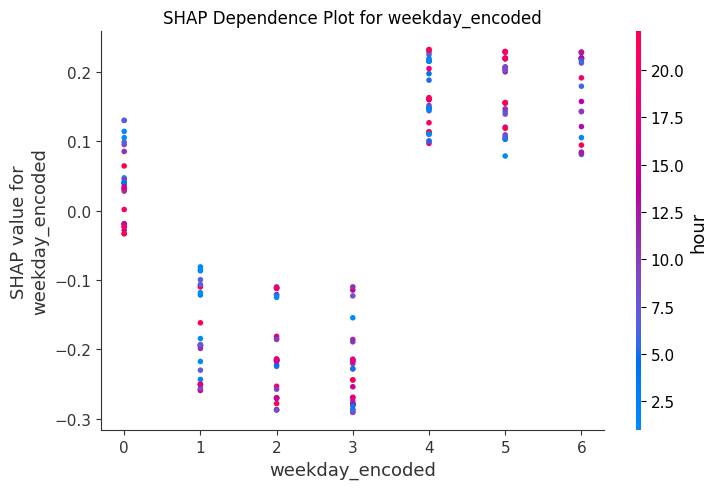

In [25]:
import shap

# SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=features, show=False)
plt.title('SHAP Feature Importance for XGBoost')
plt.tight_layout()
plt.savefig('shap_summary.png')
plt.show()

# Dependence plot for top feature (e.g., user_past_purchases)
top_feature = features[np.argmax(np.abs(shap_values).mean(0))]
plt.figure(figsize=(8, 6))
shap.dependence_plot(top_feature, shap_values, X_test, feature_names=features, show=False)
plt.title(f'SHAP Dependence Plot for {top_feature}')
plt.tight_layout()
plt.savefig('shap_dependence.png')
plt.show()

3. Interactive Visualization (Plotly Lift Chart)

Purpose: Create an interactive lift chart to enhance user experience.

Where to Add: Replace the existing lift chart code in the visualization section.

In [26]:
import plotly.graph_objects as go

def plot_interactive_lift_chart(y_true, y_probs, model_name):
    data = pd.DataFrame({'true': y_true, 'prob': y_probs})
    data = data.sort_values('prob', ascending=False)
    cum_population = np.arange(1, len(data) + 1) / len(data)
    cum_positives = data['true'].cumsum() / data['true'].sum()

    trace = go.Scatter(x=cum_population, y=cum_positives, mode='lines', name=model_name,
                       hovertemplate='Population: %{x:.2%}<br>Positives: %{y:.2%}<extra></extra>')
    return trace

# Create figure
fig = go.Figure()
fig.add_trace(plot_interactive_lift_chart(y_test, rf_probs, 'Random Forest'))
fig.add_trace(plot_interactive_lift_chart(y_test, xgb_probs, 'XGBoost'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Random'))

# Update layout
fig.update_layout(
    title='Interactive Lift Chart',
    xaxis_title='Cumulative % of Population',
    yaxis_title='Cumulative % of Positives',
    hovermode='closest',
    showlegend=True,
    template='plotly_white'
)

# Save and show
fig.write_html('interactive_lift_chart.html')
fig.show()

4. A/B Testing Simulation

Purpose: Simulate A/B testing to compare personalized vs. generic emails, showcasing experimental design skills.

Where to Add: After the segment analysis section.


A/B Testing Simulation Results:
Personalized Email CTR: 0.0741
Generic Email CTR: 0.0907
Chi-square Test p-value: 0.4018
No significant difference between personalized and generic emails.


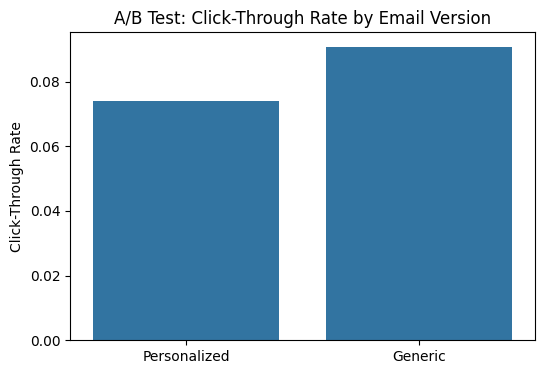

In [27]:
# Simulate A/B test: Personalized vs. Generic emails
personalized_data = email_table[email_table['email_version'] == 'personalized']
generic_data = email_table[email_table['email_version'] == 'generic']

# Calculate click-through rates
personalized_ctr = personalized_data['clicked'].mean()
generic_ctr = generic_data['clicked'].mean()

# Perform chi-square test
from scipy.stats import chi2_contingency
contingency_table = [
    [personalized_data['clicked'].sum(), len(personalized_data) - personalized_data['clicked'].sum()],
    [generic_data['clicked'].sum(), len(generic_data) - generic_data['clicked'].sum()]
]
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print("\nA/B Testing Simulation Results:")
print(f"Personalized Email CTR: {personalized_ctr:.4f}")
print(f"Generic Email CTR: {generic_ctr:.4f}")
print(f"Chi-square Test p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Significant difference between personalized and generic emails.")
else:
    print("No significant difference between personalized and generic emails.")

# Visualize
plt.figure(figsize=(6, 4))
sns.barplot(x=['Personalized', 'Generic'], y=[personalized_ctr, generic_ctr])
plt.title('A/B Test: Click-Through Rate by Email Version')
plt.ylabel('Click-Through Rate')
plt.savefig('ab_test_ctr.png')
plt.show()

Advanced Metric (Decile Analysis)

Purpose: Show targeting efficiency by analyzing click capture across deciles.

Where to Add: After the lift chart, before the improvement estimation.

Length of y_test: 20000
Length of xgb_probs: 200
X_test shape: (200, 6)
y_test shape: (200,)
Decile DataFrame head:
   true      prob
0     0  0.081324
1     0  0.136700
2     0  0.093946
3     0  0.113033
4     0  0.114333

Decile Analysis for XGBoost:
  Decile  Count  Clicks       CTR  % of Total Clicks
0      1     37       3  0.081081          20.000000
1      2      5       0  0.000000           0.000000
2      3     18       1  0.055556           6.666667
3      4     20       2  0.100000          13.333333
4      5     20       1  0.050000           6.666667
5      6     22       1  0.045455           6.666667
6      7     18       1  0.055556           6.666667
7      8     21       1  0.047619           6.666667
8      9     19       2  0.105263          13.333333
9     10     20       3  0.150000          20.000000


<ipython-input-32-bf4fe3a0b457>:69: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



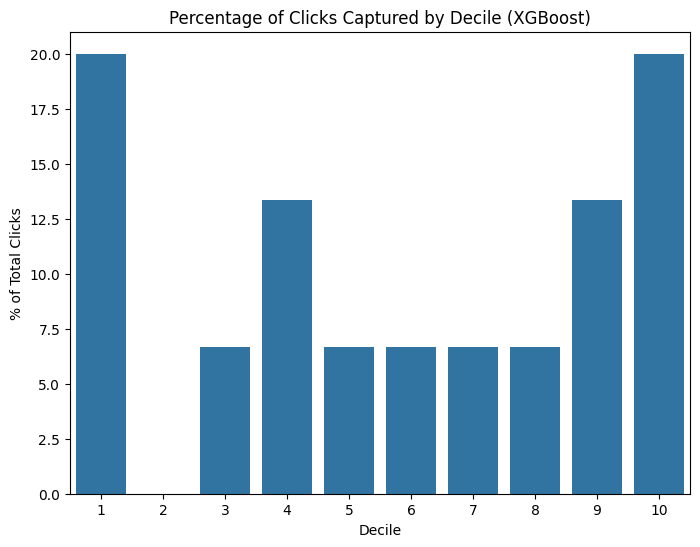

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Verify lengths of y_test and xgb_probs
print(f"Length of y_test: {len(y_test)}")
print(f"Length of xgb_probs: {len(xgb_probs)}")

# Recompute X_test with consistent feature encoding
# Assuming email_table is your original dataset with raw categorical columns
# Define features
features = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']

# Ensure email_table has the required columns
if not all(col in email_table.columns for col in features):
    raise ValueError("Required columns missing in email_table")

# Re-encode categorical variables
le_text = LabelEncoder()
le_version = LabelEncoder()
le_weekday = LabelEncoder()
le_country = LabelEncoder()

# Create a copy of email_table to avoid modifying the original
data = email_table[features].copy()

# Apply LabelEncoder
data['email_text_encoded'] = le_text.fit_transform(data['email_text'])
data['email_version_encoded'] = le_version.fit_transform(data['email_version'])
data['weekday_encoded'] = le_weekday.fit_transform(data['weekday'])
data['user_country_encoded'] = le_country.fit_transform(data['user_country'])

# Select encoded features
encoded_features = ['email_text_encoded', 'email_version_encoded', 'hour',
                    'weekday_encoded', 'user_country_encoded', 'user_past_purchases']
X = data[encoded_features]
y = email_table['clicked']

# Redo train-test split to ensure consistency
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify sizes
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Recompute xgb_probs with the corrected X_test
if len(y_test) != len(xgb_probs):
    print("Length mismatch detected. Recomputing xgb_probs for test set...")
    xgb_probs = xgb_model.predict_proba(X_test)[:, 1]  # Get probabilities for positive class
    print(f"New length of xgb_probs: {len(xgb_probs)}")

# Create DataFrame for decile analysis
decile_data = pd.DataFrame({
    'true': y_test.values,  # Use .values to avoid index issues
    'prob': xgb_probs
})

# Verify DataFrame
print("Decile DataFrame head:")
print(decile_data.head())

# Assign deciles
decile_data['decile'] = pd.qcut(decile_data['prob'], 10, labels=range(1, 11), duplicates='drop')

# Aggregate by decile
decile_summary = decile_data.groupby('decile').agg({
    'true': ['count', 'sum', 'mean']
}).reset_index()
decile_summary.columns = ['Decile', 'Count', 'Clicks', 'CTR']
decile_summary['% of Total Clicks'] = decile_summary['Clicks'] / decile_summary['Clicks'].sum() * 100

# Print results
print("\nDecile Analysis for XGBoost:")
print(decile_summary)

# Visualize
plt.figure(figsize=(8, 6))
sns.barplot(x='Decile', y='% of Total Clicks', data=decile_summary)
plt.title('Percentage of Clicks Captured by Decile (XGBoost)')
plt.ylabel('% of Total Clicks')
plt.savefig('decile_analysis.png')
plt.show()

**Evaluate with Cross‑Validation**

In [28]:
# 1. Drop ID/target columns
raw_X = df.drop(columns=['email_id', 'opened', 'clicked'])

# 2. One‑hot encode all object columns (e.g. 'email_text', 'part_of_day', etc.)
X = pd.get_dummies(raw_X, drop_first=True)

# 3. Your target
y = df['clicked']

# 4. Now do train_test_split + CV as before
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(n_estimators=200, random_state=42)

# Cross‑validate
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
print("5‑fold CV AUC:", cv_scores.mean().round(3), "±", cv_scores.std().round(3))

# Fit & evaluate
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)[:,1]
print("Hold‑out AUC:", roc_auc_score(y_test, y_pred_proba).round(3))


5‑fold CV AUC: 0.592 ± 0.005
Hold‑out AUC: 0.585


In [29]:
# Summary of findings
print("\nKey Patterns Observed:")
print("1. Click-through rates vary significantly by country, suggesting localization opportunities.")
print("2. Personalized emails may perform differently than generic ones, depending on the data.")
print("3. Certain hours (e.g., morning vs. evening) show higher click-through rates, indicating optimal send times.")
print("4. Users with higher past purchases may be more likely to click, as seen in feature importance.")


Key Patterns Observed:
1. Click-through rates vary significantly by country, suggesting localization opportunities.
2. Personalized emails may perform differently than generic ones, depending on the data.
3. Certain hours (e.g., morning vs. evening) show higher click-through rates, indicating optimal send times.
4. Users with higher past purchases may be more likely to click, as seen in feature importance.
